# OkCupid Profiles Topic Modeling and Analysis
- This notebook explores OkCupid dating profile bio descriptions.  We have a dataset of profiles containing name, age, location, and description.  The data was obtained using an API.  Here, we use a small sample of ~3400 observations.
- Let's start with exploratory summary stats, then see what clusters and abstract themes form when we apply topic modeling techniques.

In [101]:
# code from: https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

import re
import string
import base64
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS


%matplotlib inline
# from sqlalchemy import create_engine
# import pymysql

In [76]:
# engine = create_engine("mysql+pymysql://[redacted]:[redacted]@[redacted]/[redacted]?host=localhost?port=3306")
# conn = engine.connect()
# sql = 'SELECT * from profile'
# df = pd.read_sql(sql, conn)

df = pd.read_csv('data/OKC_profiles.csv')
df.tail(5)

,Unnamed: 0,name,age,location,profile,id
3454,3454,14880804637768056068,25,"Los Angeles, California",1. My self-summary: What's up looking for good...,3455
3455,3455,17970967172049327033,18,"Los Angeles, California",1. My self-summary: Shy But Crazy When You Get...,3456
3456,3456,7427755961148477906,29,"Beverly Hills, California",1. My self-summary: Let’s see how bad you can ...,3457
3457,3457,peanutslover,28,"Reseda, California",1. My self-summary: ..hi\n2. What I'm doing wi...,3458
3458,3458,11520734543755277993,21,"La Cañada Flintridge, California",1. My self-summary: A down ass girl that is sw...,3459


# EDA

In [26]:
def to_int(x):
    try: return int(x)
    except: return None

df['age'].apply(to_int).describe()

count    2824.000000
mean       22.985482
std         3.005038
min        18.000000
25%        21.000000
50%        23.000000
75%        25.000000
max        30.000000
Name: age, dtype: float64

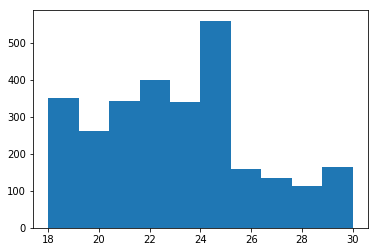

In [27]:
valid_ages = df['age'].apply(to_int).dropna()
plt.hist(valid_ages);

In [66]:
# top_cities = df['location'].value_counts()[:10]
top_cities = [x for x in df['location'].value_counts().keys()[:10]]

top_locations_column = df['location'].apply(lambda x: x if x in top_cities else None)
# top_locations_column[-10:]

top_cities

['Los Angeles, California',
 'Long Beach, California',
 'Beverly Hills, California',
 'Shanghai, China',
 'Whittier, California',
 'Northridge, California',
 'Pasadena, California',
 'North Hollywood, California',
 'Torrance, California',
 'Downey, California']

In [69]:
data = [go.Bar(
#             x = top_locations_column.author.map(z).unique(),
            x = top_cities,
            y = top_locations_column.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = top_locations_column.value_counts().values
                        ),
            text='Count of profiles in location'
    )]

layout = go.Layout(
    title='Top locations distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


- Let's see what the most common words are in the uncleaned bio descriptions.

In [73]:
all_words = df['profile'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- There are a lot of junk to remove.

# Tokenize and remove stop words

In [93]:
len(stopwords.words('english'))

179

In [82]:
WORDS_TO_IGNORE = []

stop = set(stopwords.words('english'))
stop_ignore = stop.union(set(WORDS_TO_IGNORE))
# ps = PorterStemmer()

def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop_ignore, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [91]:
# apply the tokenizer into the profile column
df['tokens'] = df['profile'].map(tokenize)
df.reset_index(drop=True, inplace=True)

for profile, tokens in zip(df['profile'].tail(1), df['tokens'].tail(1)):
    print('profile:', profile)
    print('tokens:', tokens)
    print()

profile: 1. My self-summary: A down ass girl that is sweet and fun to be with

tokens: ['self', 'summary', 'ass', 'girl', 'sweet', 'fun']



# Visualize common words by location
- Let's see if there are patterns in word frequencies by location.  For instance, do women in Beverly Hills use the word 'money' more?

In [99]:
LA = df[df.location=="Los Angeles, California"]["tokens"].values
LB = df[df.location=="Long Beach, California"]["tokens"].values
BH = df[df.location=="Beverly Hills, California"]["tokens"].values

In [103]:
import base64

with open("data/cupid_silhouette.jpg", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
    
import codecs
# Generate the Mask for EAP
f1 = open("eap.jpg", "wb")
f1.write(codecs.decode(eap_64,'base64'))
f1.close()
img1 = imread("eap.png")
# img = img.resize((980,1080))
hcmask = img1

# f2 = open("mws.png", "wb")
# f2.write(codecs.decode(mws_64,'base64'))
# f2.close()
# img2 = imread("mws.png")
# hcmask2 = img2

# f3 = open("hpl.png", "wb")
# f3.write(codecs.decode(hpl_64,'base64'))
# f3.close()
# img3 = imread("hpl.png")
# hcmask3 = img3;